# AI Chat Bot training session using Deep learning
## A comparative study of deep neural networks
### Authors: Soyeong Bak, Dabeen Oh, Emmanuel Ren

## Introduction

This notebook presents the deep learning models training process and their performance regarding to a homemade dataset (<b>8 labels and 893 labeled sentences</b>). This study draws a <b>comparison</b> between models with different levels of complexity: from basic neural networks to most sophisticated transformer-based model (for instance, Bert). 
All the models are based on the Tensorflow Keras Deep Learning Framework.

Some of the models are <b>pre-trained</b> models from tensorflow-hub and fine_tuned using our data (NNLM and BERT), others are directly trained (FCNN and LSTM).

The code and the performance results will be illustrated by insights and explainations on the models architecture.

## Importation of the coded library

For more details on the preprocessing methods used and the architecture of the models, please look at the class library "ai_bot.py" in the same directory, accessible from the following github link: https://github.com/eren125/AmExChall2020

ai_bot.LoadingData imports the data from "/data/intents.json" and has some preprocessing methods encoded.

In [2]:
import ai_bot
import matplotlib.pyplot as plt

data = ai_bot.LoadingData() # A class containing preprocessed data
X_train, Y_train = data.X_train,data.Y_train # text data (train)
X_test, Y_test = data.X_test,data.Y_test # text data (test)
_clean_text,_tensorize = data._clean_text,data._tensorize
print("Training set's size: %s \nTest set's size: %s"%(len(X_train),len(X_test)))
print("Categories:")
print(data.cat_to_tag)

Training set's size: 732 
Test set's size: 161
Categories:
{0: 'animals', 1: 'cruise', 2: 'food ', 3: 'greeting', 4: 'historical', 5: 'night tour', 6: 'relaxation', 7: 'show_concerts'}


## Locally trained model

### Fully connected neural network
  
The fully connected neural network is what we would usually call a conventional neural network. It has the simplest architecture imaginable for a classification task. For example, the classification of handwritten number images (MNIST dataset) is usually tackled by a FCNN as an introduction to deep learning.
  
This approach needs to take as an input an array of vectors (a tensor) and return another array of vector. For example, [1,0,0,0,0,0,0,0] corresponds to the label "animals" in the output word and [1,0,...,0] corresponds to "Hello" in the in put word (not really the case, but just to give an illustration). Basically, this type of representation is called "bag-of-words", we limit the size of the vocabulary to 500 stemmed words and we count the number of time they appear in the sentence considered. 
  
Let's see the results we got from such a model:

In [2]:
# Full bag-of-words / FCNN does not work (accuracy low even with a high dimensionality 430k params)
Model = ai_bot.ModelFcnn()
# Preprocess data into bag-of-words
X_train_,Y_train_ = Model.get_input_array(X_train,_clean_text,_tensorize),Y_train # bag-of-words (train)
Model._build(X_train_,Y_train_)
Model._train(X_train_,Y_train_,epochs = 20,batch_size = 8,validation_split=0.1)

Shape of data tensor: (732, 250)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               256512    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)        

As expected FCNN does not perform very well (accuracy around 18% for validation and training) because the only feature that it takes into account is the occurence of a word, but we know that the <b>context</b>, the <b>order</b> of the words and the <b>meaning</b> of the words are extremely important in language modeling. 

Using a bag-of-words approach, 'cat' is as far from 'dog' than 'computer' in the vectorized word. Because they would each form a unique category in the 500 words vocabulary bag. The meaning of the words are not considered.

Moreover, when we say 'I can sing' it is not the same as 'Can I sing?'. The order of the words infers a difference in the overall meaning of the sentence.

The context where a word stand can completely change its meaning. For instance, in "I got a bicycle." and "I got it.", the verb "to get" means respectively "to obtain" and "to understand", which are pretty different. In the same sentence, we can also have change in the meaning "The leaves fall during Fall.", "fall" has very different meaning and grammatical nature.

To sum-up, the FCNN model can not build a relevent word representation in order to classify sentences.

A more robust way of tackling the problem, is to use embedding techniques to respresent the sequence vectors inside a high dimension world. I will explain the approach in the following subsection.

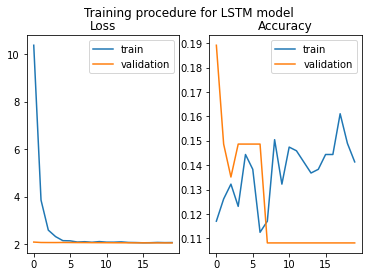

In [3]:
history = Model.model.history.history
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle("Training procedure for LSTM model")
ax1.set_title('Loss')
ax1.plot(history['loss'], label='train')
ax1.plot(history['val_loss'], label='validation')
ax1.legend()
ax2.set_title('Accuracy')
ax2.plot(history['accuracy'], label='train')
ax2.plot(history['val_accuracy'], label='validation')
ax2.legend()

By looking at the curves above, it seems that the model has reached its minimum loss, this more of a model architecture problem than a training procedure problem.

FCNN has only <b>11.18%</b> of test accuracy.

In [4]:
X_test_, Y_test_ = Model.get_input_array(X_test,_clean_text,_tensorize),Y_test # text data (test)
loss, accuracy = Model.model.evaluate(X_test_, Y_test_)
print("Test accuracy: %s"%accuracy)


Shape of data tensor: (161, 250)
6/6 [==============================] - 0s 2ms/step - loss: 2.0470 - accuracy: 0.1118
training accuracy: 0.11180124431848526


### Word Embeddings & Long short-term memory (LSTM) Recurrent Neural Network

#### Context
The <b>word embedding</b> technique consists in training the coefficient of a matrix or tensor that changes a word (encoded by a number) into a vector. For instance, if "Hello" is encoded by a 1. The sentence "Hello" will be a <i>N</i>-dimension vector [1,0,...,0] and the embedding tensor will transform this vector into a <i>NxM</i> matrix: [[1,...,1],[0,..,0],...,[0,...,0]] where <i>N</i> is the maximum number of words in a sentence allowed and <i>M</i> is the high dimension space where the words are represented. In the code ai_bot.py, <i>N</i> is called <i>MAX_SEQUENCE_LENGTH</i> and <i>M</i> is <i>EMBEDDING_DIM</i>.

After applying the embedding layers to a set of sentences (training session), we a transformed a 2D matrix (list of sentences) into a 3D matrix (list of NxM matrixes). The trained embedding layers are expected to extract the meaning of each word and place them in a M dimension word (see below).

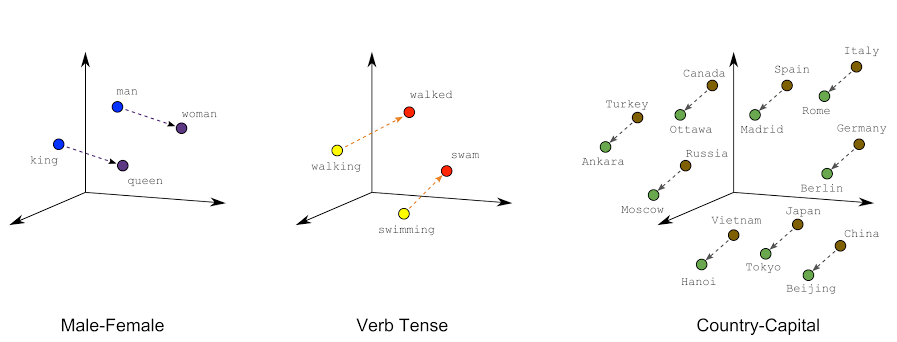

The RNN layer takes this list of sequences of word vectors to reduce the dimensionality and extract an overall meaning for each sentence. The exact definition of the features extracted by the RNN network can't be simply explained, but we know that it uses the order of the words, their meaning (word representation) and the context is partially understood since it feeds the output with the outputs of the previous words. A Recurrent network adds feedback systems (see figure below) that allows it to build a context understanding.

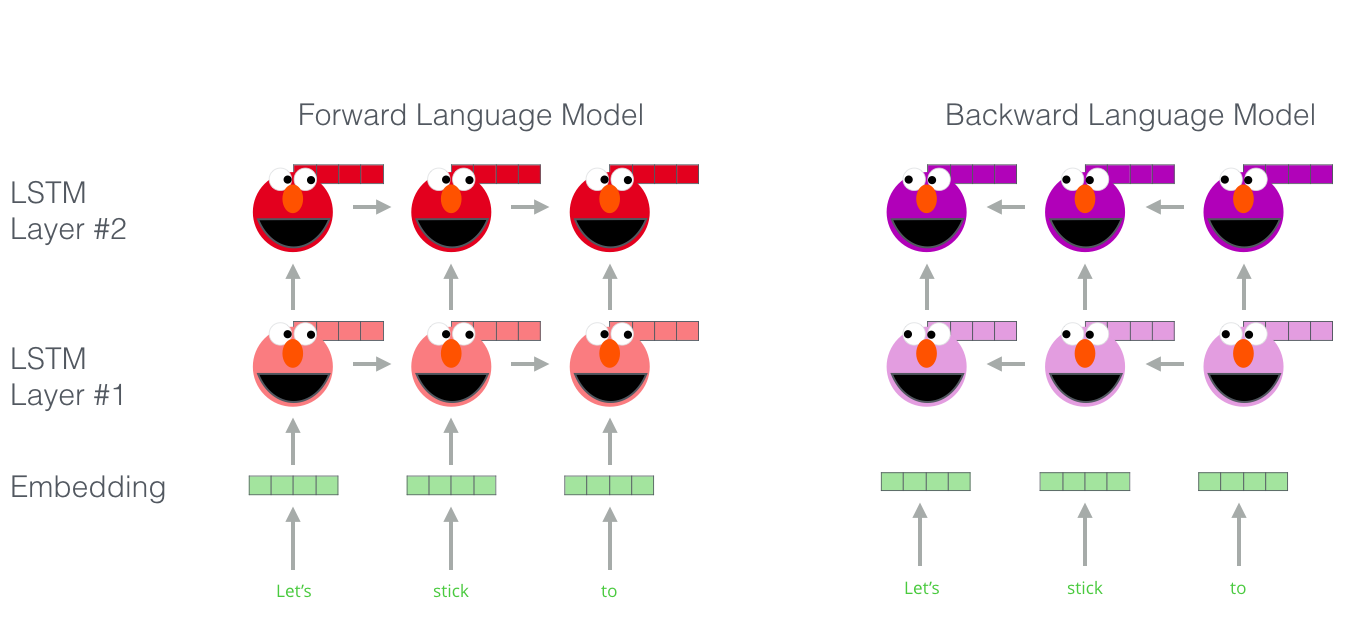

A problem arises in RNN: it can't keep memorizing every previous words. The memory vanishes along a sentence, this is called the gradient vanishing problem. In cases, where the most important context word is very far from the concerned word. for example, "The girl I [...], she was kind." To understand "she", we need "girl" which is quite far one from each other. The Long short-term memory units helps the RNN to overcome this problem by training the problem to forget the unimportant words and memorizing the important ones (see below). 

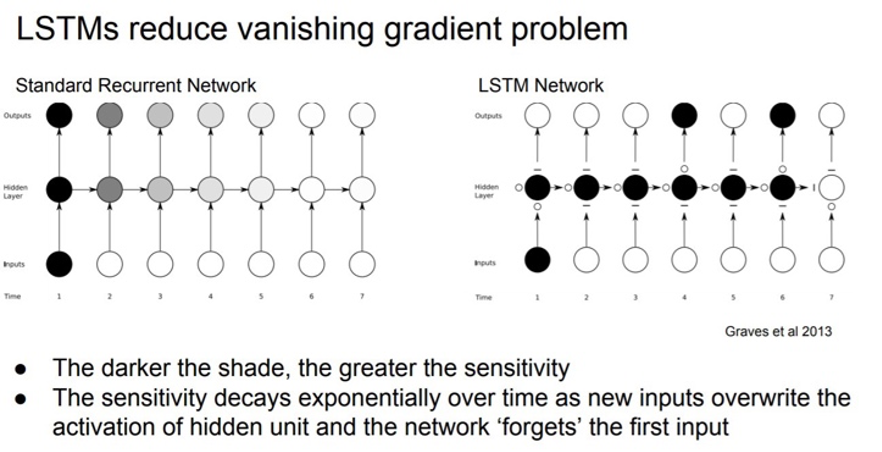

This model represents a big improvement compared to the conventional neural networks in language modeling, beacause it has the capacity to model the meaning of the words through embedding and to figure out a context with the LSTM network. 

The only problem of such a model is its unidirectionality, the information either are fed forward or backward as shown in the figure above. Since the order matters for the meaning of a sentence, this could be an issue to properly model a sentence. This is why, more complex models have been developped bidirectional LSTM that combines forward and backward LSTM models and the bidirectional encoder representations from transformers (BERT). 

We will explain the latter in the last section that deals with the  pre-trained models that we used during this Hackathon Challenge.

#### Results
A summary of the structure of the LSTM network is given below, for more details on the network's architecture, please look at the python code <i>ai_bot.py</i>.
For batches of 8 sentences and a validation split of 15% over 20 epochs, the model reached a maximum validation accuracy at the tenth epoch and the weights have been saved. 

This model represents a less overfit version of the model with <b>99.68%</b> training accuracy and <b>90.90%</b> validation accuracy on a 732 sentences training set (110 validation / 622 training).

In [5]:
# Long-short term memory model with embedding
Model = ai_bot.ModelLstm()
# Preprocess data into sequences
X_train_,Y_train_ = Model.get_input_array(X_train,_clean_text,_tensorize),Y_train # Preprocess data so that it corresponds to the model
Model._build(X_train_,Y_train_,EMBEDDING_DIM = 128)
Model._train(X_train_,Y_train_,epochs = 20,batch_size = 8,validation_split=0.15)

Shape of data tensor: (732, 250)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 128)          64000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1032      
Total params: 196,616
Trainable params: 196,616
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 2.0123 - accuracy: 0.3248
Epoch 00001: val_accuracy improved from -inf to 0.76364, saving model to model/LSTM.h5
78/78 [=========================

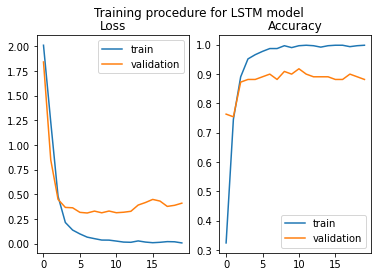

In [6]:
history = Model.model.history.history
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle("Training procedure for LSTM model")
ax1.set_title('Loss')
ax1.plot(history['loss'], label='train')
ax1.plot(history['val_loss'], label='validation')
ax1.legend()
ax2.set_title('Accuracy')
ax2.plot(history['accuracy'], label='train')
ax2.plot(history['val_accuracy'], label='validation')
ax2.legend()

The test is done on 18% of the dataset (161 sentences).<br>
We obtain a test accuracy of <b>92.55%</b>

In [7]:
X_test_, Y_test_ = Model.get_input_array(X_test,_clean_text,_tensorize),Y_test # text data (test)
loss, accuracy = Model.model.evaluate(X_test_, Y_test_)
print("Test accuracy: %s"%accuracy)


Shape of data tensor: (161, 250)
6/6 [==============================] - 0s 54ms/step - loss: 0.2937 - accuracy: 0.9255
training accuracy: 0.9254658222198486


## Pre-trained model

### Recurrent Neural Network language model

This model is based on a recurrent neural network that aims at representing the words in a distributed representation in order to fight the curse of dimensionality (words of the test set have a very high probability to be different from the words of the training set). Our embedding representation is just a very small subspace of the possible word space.

For more details on the model please look at this paper:<br> <a href="https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf">Yoshua Bengio, Réjean Ducharme, Pascal Vincent, Christian Jauvin. A Neural Probabilistic Language Model. Journal of Machine Learning Research, 3:1137-1155, 2003</a>.

We take the weights of this RNNLM model from <a href="https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1">tensorflow-hub</a> and pretrain it using keras. 

The final model (epoch 14) has an training accuracy of <b>96.14%</b> and a validation accuracy of <b>91.81%</b>.

In [8]:
# A model using a pretrained RNN model with a simple FClayer for the classification
Model = ai_bot.ModelRnnlm()
# Preprocess sentences into cleaned sentences
X_train_,Y_train_ = Model.get_input_array(X_train,_clean_text,_tensorize),Y_train # cleant sentences (train)
Model._build(X_train_,Y_train_)
Model._train(X_train_,Y_train_,epochs = 20,batch_size = 8,validation_split=0.15)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 408       
Total params: 48,191,008
Trainable params: 48,191,008
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 2.0711 - accuracy: 0.1672
Epoch 00001: val_accuracy improved from -inf to 0.27273, saving model to model/RNNLM.h5
78/78 [==============================] - 56s 723ms/step - loss: 2.0711 - accuracy: 0.1672 - val_loss: 1.9532 - val_accuracy: 0.2727
Epoch 2/20
78/78 [==============================] - ETA: 0

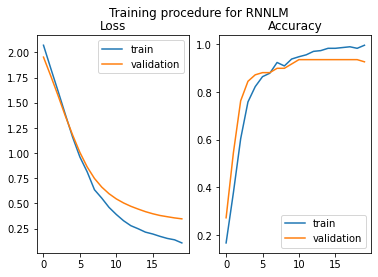

In [10]:
history = Model.model.history.history
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle("Training procedure for RNNLM")
ax1.set_title('Loss')
ax1.plot(history['loss'], label='train')
ax1.plot(history['val_loss'], label='validation')
ax1.legend()
ax2.set_title('Accuracy')
ax2.plot(history['accuracy'], label='train')
ax2.plot(history['val_accuracy'], label='validation')
ax2.legend()

The test is done on 18% of the dataset (161 sentences).<br>
We obtain a test accuracy of <b>93.17%</b>

In [11]:
X_test_, Y_test_ = Model.get_input_array(X_test,_clean_text,_tensorize),Y_test # text data (test)
loss, accuracy = Model.model.evaluate(X_test_, Y_test_)
print("Test accuracy: %s"%accuracy)


6/6 [==============================] - 1s 100ms/step - loss: 0.3180 - accuracy: 0.9317
training accuracy: 0.9316770434379578


Even with the leverage of a pre-training, this model performs quite similarly to the LSTM model. It is slightly less overfit with much closer validation/training/testing accuracies than the LSTM model. Th accuracy on the test set is slightly better. Even if more data has been fed into the model to pre-train the model, the lack of bidirectionality may explain this inefficiency.

### Bidirectional Encoder Representation from Transformers (BERT)

#### Introduction

BERT is a well-rounded model described in this <a href="https://arxiv.org/pdf/1810.04805.pdf">paper</a> published by the researchers at Google AI Language. It is now considered as the state-of-the-art in NLP tasks because of its performance. BERT's key technical innovation is the use of bidirectional training of transformers called attention model in language modelling. If we were to sum-up the model in three key words, they would be: attention, mask and next sentence prediction (NSP).

Bert model can learn the context of a word by reading at once the entire sequence of words which makes it non-directional (to be accurate) but in reference to other methods such as bidirectional LSTM (ELMo), it is called bidirectional. This mechanism is called <b>attention</b> mechanism. 

Its training strategy is also remarkable, it uses <b>masks</b> to learn the meaning of the words. For example, 15% of the words are replaced by [MASK] token and are to be predicted by the model. This allows the model to learn on unlabeled datasets such as the Wikipedia articles. In practice the strategy is slightly different see <a href="https://www.lyrn.ai/2018/11/07/explained-bert-state-of-the-art-language-model-for-nlp/#appendix-A">Appendix A</a> for more information.

The <b>next sentence prediction</b> trains the model to assert whether two sentences are connected or not. For that, we take random sentences in texts which 50% are paired with the next sentence and 50% are paired with randomly chose sentence. Under the assumption that two randomly chosen sentences are not linked, the model is trained to recognise related sentences. This training procedure does not require any labeling too, it just requires a preprocessing algorithm applied to some raw texts dataset to generate those pairs and automatically label them.

Both of these training strategies are trained in parallel with the goal of minimizing the combined loss of both of these training (masks prediction and next sentence prediction).

#### Results

BERT combined with a "softmax" activated dense layer can be ideal for text classification, as it leverages the 4 days of 4 cloud TPUs training that the BERT model used to train BERT_Base. We tried this transfer learning using the Bert modeled hosted in <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2tensorflow-hub">this tensorflow hub</a> and it worked very well in the prediction of our 8 labels using 893 sentences.

The training on a laptop CPU was used to fine-tune this 110 million parameter-model in order to fit to our classification problem (it took about 7 hours for 7 epochs).

The final model (epoch 4) has an training accuracy of <b>99.20%</b> and a validation accuracy of <b>99.09%</b>.

In [12]:
# BERT training to fine-tune the pre-trained parameters
Model = ai_bot.ModelBert(512,Y_train.shape[1])
# Preprocess data into sequences
X_train_,Y_train_ = Model.get_input_array(X_train,_clean_text,_tensorize),Y_train # Preprocess data so that it corresponds to the model
Model.bert_model()
Model._train(X_train_,Y_train_,epochs = 7,batch_size = 8,validation_split=0.15)

100%|██████████| 732/732 [00:00<00:00, 4906.03it/s]
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_ids[0][0]                  
                                   

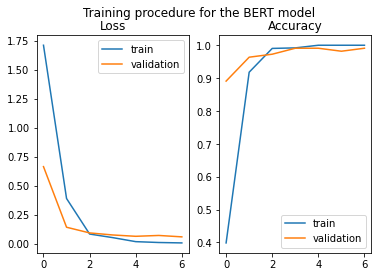

In [13]:
history = Model.model.history.history
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle("Training procedure for the BERT model")
ax1.set_title('Loss')
ax1.plot(history['loss'], label='train')
ax1.plot(history['val_loss'], label='validation')
ax1.legend()
ax2.set_title('Accuracy')
ax2.plot(history['accuracy'], label='train')
ax2.plot(history['val_accuracy'], label='validation')
ax2.legend()

We obtain a test accuracy of <b>96.89%</b>

In [15]:
X_test_, Y_test_ = Model.get_input_array(X_test,_clean_text,_tensorize),Y_test # text data (test)
loss, accuracy = Model.model.evaluate(X_test_, Y_test_)
print("Test accuracy: %s"%accuracy)


6/6 [==============================] - 198s 33s/step - loss: 0.0723 - accuracy: 0.9689
Test accuracy: 0.9689440727233887


Text(0.5, 1.0, 'Test accuracy comparison between the studied DL models')

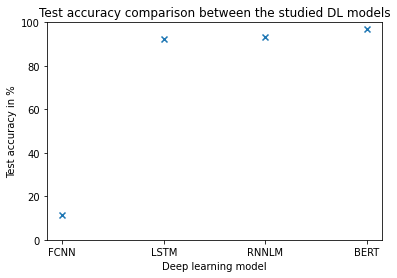

In [6]:
test_acc = [11.18,92.55,93.17,96.89]
model = ['FCNN','LSTM','RNNLM','BERT']
plt.scatter(model,test_acc,marker='x')
plt.xlabel("Deep learning model")
plt.ylabel("Test accuracy in %")
plt.ylim(bottom=0,top=100)
plt.title("Test accuracy comparison between the studied DL models")

## Conclusion

This notebook gives us some insights on how the nlp deep learning models can be used to solve a classification problem. We saw some important concept to master for this type of modeling, such as feedback mechanisms (RNN), directionality (forward/backward feedback), forget gates (to prevent gradient vanishing issues in RNN), curse of dimension (NNLM), attention mechanism, mask prediction and next sentence prediction (BERT). 

The more complex the model is, the more accurate it is as the plot above shows it. As indicators of complexity we can ask the model how it hadles meaning, word orders and context and then whether it has been trained (including pre-training) on a large dataset. Usually the bigger the training set is, the more parameters we need. 

BERT gives outstanding results on this classification problem of 8 intents with 893 sentences. Its performance can be further tested through conversation with amexbot in Slack. The amexbot Chatbot was implemented using these four models. You will be able to see the intents that each model predicts and their level of confidence.

To interact with amexbot, simply join the slack team via this Link: <a href="https://join.slack.com/t/dorebeen/shared_invite/zt-gne8osn9-5YUofOA9m7fZwy1roaePAA">Join us in Slack</a>